<a href="https://colab.research.google.com/github/fnazihfa/Sentiment-Analysis/blob/main/Sentiment_Analysis_of_Facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using Play Store Reviews with Deep Learning

## Importing Libraries

In [ ]:
#!pip install vaderSentiment

In [ ]:
# ──────────────────────────────────────────────────────────────
# DATA ACQUISITION
import numpy as np
import pandas as pd

# ──────────────────────────────────────────────────────────────
# TEXT PREPROCESSING
import re
import string
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# ──────────────────────────────────────────────────────────────
# DATA SAVING
import pickle

# ──────────────────────────────────────────────────────────────
# FEATURE EXTRACTION
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ──────────────────────────────────────────────────────────────
# MACHINE LEARNING / MODELING
from sklearn.model_selection import train_test_split

# ──────────────────────────────────────────────────────────────
# DEEP LEARNING (TensorFlow / Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    LSTM,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# ──────────────────────────────────────────────────────────────
# VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ──────────────────────────────────────────────────────────────
# SENTIMENT ANALYSIS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Loading Dataset

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/fb_reviews.csv')

# Display the first 5 rows
df.head()

reviewId       userName  \
0  98efbc0a-faf1-49d5-8f9e-f3495c0086a8  A Google user   
1  4fdd5f9c-d80d-4679-a243-84ff42c05a7d  A Google user   
2  e2466ee6-e85c-43c8-b8cc-29a41906605f  A Google user   
3  1e18fb86-165a-4e3e-9329-7128eae954a2  A Google user   
4  91620db6-5cec-47ac-a6a4-c88582de0a35  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Constantly freezes and shuts down. They never ...      1           1967   
1  Facebook games are very unstable!!!! I play Lu...      1           1919   
2  Please reset the search options. I used to be ...      1           8838   
3  3/2/23: Can you please stop making every updat...      2           4578   
4  The User Interface of this app is one of the w...      1           9953   

  reviewCreatedVersion                   at  replyContent  repliedAt  \
0        504.0.0.69.64  2025-03-23 18:56:08           NaN        NaN   
1        505.0.0.57.45  2025-03-20 22:33:52           NaN        NaN   
2        503.0.0.69.76  2025-03-13 11:43:54           NaN        NaN   
3        502.0.0.66.79  2025-03-06 03:15:54           NaN        NaN   
4        496.0.0.45.65  2025-01-20 05:43:42           NaN        NaN   

      appVersion  
0  504.0.0.69.64  
1  505.0.0.57.45  
2  503.0.0.69.76  
3  502.0.0.66.79  
4  496.0.0.45.65

We drop any duplicates and Nan values

In [ ]:
clean_fbreviews = df.drop_duplicates(subset=['content'])
clean_fbreviews = clean_fbreviews.dropna(subset=['content'])

In [ ]:
clean_fbreviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210518 entries, 0 to 211499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewId              210518 non-null  object 
 1   userName              210518 non-null  object 
 2   userImage             210518 non-null  object 
 3   content               210518 non-null  object 
 4   score                 210518 non-null  int64  
 5   thumbsUpCount         210518 non-null  int64  
 6   reviewCreatedVersion  192401 non-null  object 
 7   at                    210518 non-null  object 
 8   replyContent          0 non-null       float64
 9   repliedAt             0 non-null       float64
 10  appVersion            192401 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 19.3+ MB


## Data Cleaning and Preprocessing

Here are several functions used to clean and process text. Below is a brief explanation of each function:

**`cleaningText(text)`**  
This function is used to clean the text through several steps, such as removing mentions (`@username`), hashtags (`#topic`), retweet symbols (`RT`), links, numbers, and punctuation marks. It also replaces newline characters with spaces and removes extra spaces at the beginning and end of the text.

**`casefoldingText(text)`**  
This function converts all characters in the text to lowercase, making the text more uniform and easier to process.

**`tokenizingText(text)`**  
This function splits the text into a list of words or tokens. It is useful for breaking down the text into its basic components for further processing.

**`lemmitizingText(text)`**  
This function performs lemmatization, which reduces words to their base or dictionary form (e.g., "running" becomes "run"). It uses the spaCy library to carry out lemmatization in English.

**`toSentence(list_words)`**  
This function converts a list of words back into a full sentence by joining the tokens with spaces.

You can use these functions in your project to clean, process, and prepare the text before performing sentiment analysis. Make sure to call these functions in the correct sequence based on the text preprocessing pipeline you wish to implement.

In [ ]:
# Download NLTK punkt_tab
nltk.download('punkt_tab')

# Download NLTK stopwords (only needed once)
nltk.download('stopwords')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

stemmer = PorterStemmer()


def cleaningText(text):
    # Remove mentions, hashtags, retweet symbols, links, numbers
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # hashtags
    text = re.sub(r'\brt\b', '', text)          # RT (with word boundary)
    text = re.sub(r"http\S+|www.\S+", '', text) # links
    text = re.sub(r'\d+', '', text)             # numbers
    text = re.sub(r'[^\w\s]', '', text)         # punctuations

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace/newlines
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces into one
    text = text.strip()

    return text


def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text


def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text


def lemmitizingText(text): # Lemmitization
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc]  # Keep only words (no punct, no digits)
    return ' '.join(lemmatized)


def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
slangwords = {
    "fb" : "facebook",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "btw": "by the way",
    "idk": "i don't know",
    "smh": "shaking my head",
    "lmao": "laughing my ass off",
    "brb": "be right back",
    "ttyl": "talk to you later",
    "fyi": "for your information",
    "tbh": "to be honest",
    "rofl": "rolling on the floor laughing",
    "bff": "best friends forever",
    "imo": "in my opinion",
    "afk": "away from keyboard",
    "omw": "on my way",
    "gtg": "got to go",
    "wyd": "what you doing",
    "srsly": "seriously",
    "ty": "thank you",
    "np": "no problem",
    "yolo": "you only live once",
    "xoxo": "hugs and kisses",
    "dm": "direct message",
    "nvm": "never mind",
    "cya": "see you",
    "ppl": "people",
    "bbl": "be back later",
    "tmi": "too much information",
    "l8r": "later",
    "ftw": "for the win",
    "wtf": "what the heck",
    "slay": "perform really well",
    "fam": "family",
    "lit": "amazing or excellent",
    "savage": "bold or ruthless",
    "noob": "newbie, inexperienced",
    "tbh": "to be honest",
    "fomo": "fear of missing out",
    "bruh": "brother (used to express surprise or disbelief)",
    "chill": "relax or calm down",
    "lmk": "let me know",
    "fml": "f**k my life",
    "smdh": "shaking my damn head",
    "yasss": "expression of excitement or approval",
    "mood": "a relatable feeling",
    "thx": "thanks",
    "gr8": "great",
    "pmsl": "pissing myself laughing",
    "omfg": "oh my f**king god",
    "smh": "shaking my head",
    "lml": "laughing mad loud",
    "hmu": "hit me up",
    "ttyl": "talk to you later",
    "wyd": "what are you doing",
    "wbu": "what about you",
    "bb": "bye bye",
    "goat": "greatest of all time",
    "sksksk": "expression of excitement (especially used by VSCO girls)",
    "lmao": "laughing my ass off",
    "icymi": "in case you missed it",
    "tmi": "too much information",
    "bffl": "best friends for life",
    "ygtbkm": "you gotta be kidding me",
    "gg": "good game",
    "np": "no problem",
    "btw": "by the way",
    "wtf": "what the heck",
    "chillax": "chill and relax",
    "yas": "yes",
    "zomg": "oh my god (exaggerated)",
    "jfc": "jesus f**king christ",
    "roflmao": "rolling on the floor laughing my ass off",
    "l8": "late",
    "smh": "shaking my head",
    "lmao": "laughing my ass off",
    "yolo": "you only live once",
    "af": "as f**k",
    "ftw": "for the win",
    "lmfao": "laughing my f**king ass off",
    "stfu": "shut the f**k up",
    "mfw": "my face when",
    "bruh": "brother",
    "big mood": "something that is highly relatable",
    "bae": "before anyone else (referring to a significant other)",
    "goals": "something to aspire to",
    "slaps": "something that is amazing or impressive",
    "sus": "suspicious or shady",
    "k": "okay",
    "boi": "boy (often used sarcastically)",
    "thirsty": "desperate for attention",
    "extra": "over the top or excessive",
    "meme": "a humorous or viral internet image or video",
    "vibe": "mood or energy",
    "lit": "amazing or exciting",
    "lowkey": "a subtle or private thing",
    "highkey": "an open or obvious thing",
    "spilling tea": "gossiping or revealing secrets",
    "stan": "to support or be a fan of someone or something",
    "clout": "influence or power, often related to social media"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

 `slangwords` **Dictionary**

This is a dictionary that maps slang or informal abbreviations commonly used in casual conversation or online messaging (e.g., “lol”, “omg”, “brb”) to their full or formal equivalents (e.g., “laughing out loud”, “oh my god”, “be right back”). The purpose of this dictionary is to normalize informal language and improve the accuracy of downstream tasks like sentiment analysis, classification, or keyword extraction.

`fix_slangwords(text)`
This function replaces any slang words found in the input text with their corresponding formal versions using the `slangwords` dictionary. Here’s how it works:
1. It splits the input text into individual words.
2. For each word, it checks whether the word exists in the slang dictionary.
3. If it does, it replaces it with the formal version.
4. If not, it keeps the word as it is.
5. Finally, it joins the words back into a complete sentence.

This function helps in standardizing informal or slang-rich text, making it cleaner and more consistent for analysis. It is especially useful for processing social media content, chats, or any user-generated text where slang is commonly used.

In [ ]:
# Convert all the characters in the cleaned text to lowercase
clean_fbreviews['text_casefoldingText'] = clean_fbreviews['content'].apply(casefoldingText)

# Replace slang words in the case-folded text with their standard equivalents
clean_fbreviews['text_slangwords'] = clean_fbreviews['text_casefoldingText'].apply(fix_slangwords)

# Apply lemmitization to the cleaned text
clean_fbreviews['text_lemmitizingText'] = clean_fbreviews['text_slangwords'].apply(lemmitizingText)

# Clean the text by removing mentions, hashtags, retweet symbols, links, numbers, punctuation, and extra whitespace
clean_fbreviews['text_clean'] = clean_fbreviews['text_lemmitizingText'].apply(cleaningText)

# Tokenize the slang-fixed text into individual words (tokens)
clean_fbreviews['text_tokenizingText'] = clean_fbreviews['text_clean'].apply(tokenizingText)

# Rejoin the filtered tokens back into a clean sentence
clean_fbreviews['text_final'] = clean_fbreviews['text_tokenizingText'].apply(toSentence)

Here we are not using stopword removal since we have observed it removes many essential words which are crucial for understanding the sentiment of a sentence, it's positive and negative aspects

We have done **casefolding** before **cleaning** since we want to use **lemmitization** after **slangwords conversion** which does most of the cleaning automatically which we then clean to remove any left over residues

Finally we tokenize the text and make the final text

In [ ]:
clean_fbreviews.head()

reviewId       userName  \
0  98efbc0a-faf1-49d5-8f9e-f3495c0086a8  A Google user   
1  4fdd5f9c-d80d-4679-a243-84ff42c05a7d  A Google user   
2  e2466ee6-e85c-43c8-b8cc-29a41906605f  A Google user   
3  1e18fb86-165a-4e3e-9329-7128eae954a2  A Google user   
4  91620db6-5cec-47ac-a6a4-c88582de0a35  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Constantly freezes and shuts down. They never ...      1           1967   
1  Facebook games are very unstable!!!! I play Lu...      1           1919   
2  Please reset the search options. I used to be ...      1           8838   
3  3/2/23: Can you please stop making every updat...      2           4578   
4  The User Interface of this app is one of the w...      1           9953   

  reviewCreatedVersion                   at  replyContent  repliedAt  \
0        504.0.0.69.64  2025-03-23 18:56:08           NaN        NaN   
1        505.0.0.57.45  2025-03-20 22:33:52           NaN        NaN   
2        503.0.0.69.76  2025-03-13 11:43:54           NaN        NaN   
3        502.0.0.66.79  2025-03-06 03:15:54           NaN        NaN   
4        496.0.0.45.65  2025-01-20 05:43:42           NaN        NaN   

      appVersion                               text_casefoldingText  \
0  504.0.0.69.64  constantly freezes and shuts down. they never ...   
1  505.0.0.57.45  facebook games are very unstable!!!! i play lu...   
2  503.0.0.69.76  please reset the search options. i used to be ...   
3  502.0.0.66.79  3/2/23: can you please stop making every updat...   
4  496.0.0.45.65  the user interface of this app is one of the w...   

                                     text_slangwords  \
0  constantly freezes and shuts down. they never ...   
1  facebook games are very unstable!!!! i play lu...   
2  please reset the search options. i used to be ...   
3  3/2/23: can you please stop making every updat...   
4  the user interface of this app is one of the w...   

                                text_lemmitizingText  \
0  constantly freeze and shut down . they never s...   
1  facebook game be very unstable ! ! ! ! I play ...   
2  please reset the search option . I use to be a...   
3  3/2/23 : can you please stop make every update...   
4  the user interface of this app be one of the b...   

                                          text_clean  \
0  constantly freeze and shut down they never see...   
1  facebook game be very unstable I play ludo wor...   
2  please reset the search option I use to be abl...   
3  can you please stop make every update come wit...   
4  the user interface of this app be one of the b...   

                                 text_tokenizingText  \
0  [constantly, freeze, and, shut, down, they, ne...   
1  [facebook, game, be, very, unstable, I, play, ...   
2  [please, reset, the, search, option, I, use, t...   
3  [can, you, please, stop, make, every, update, ...   
4  [the, user, interface, of, this, app, be, one,...   

                                          text_final  
0  constantly freeze and shut down they never see...  
1  facebook game be very unstable I play ludo wor...  
2  please reset the search option I use to be abl...  
3  can you please stop make every update come wit...  
4  the user interface of this app be one of the b...

## Labeling

For labelling we are going to use `Vader`

**VADER (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool specifically designed to detect sentiment in social media text and other informal communication. Unlike traditional sentiment analysis tools that may require large amounts of training data, VADER is pre-trained and works effectively out of the box.

**Key Features of VADER:**
- **Lexicon-based**: VADER uses a dictionary that maps words to their corresponding sentiment scores.
- **Rule-based system**: It considers grammatical and syntactical cues such as:
  - Capitalization for emphasis (e.g., *"I am HAPPY"*)
  - Punctuation like exclamation marks (e.g., *"Great!!!"*)
  - Degree modifiers or intensifiers (e.g., *"very good"* vs *"good"*)
  - Conjunctions and contrastive conjunctions (e.g., *"but"*)
  - Slang, acronyms, and emoticons (e.g., *"lol"*, *"smh"*, *":)"*)

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis_vader(text):
    # Join list of words or sentences into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Get sentiment scores
    score = analyzer.polarity_scores(text)
    compound = score['compound']

    # Determine sentiment
    if compound >= 0.05:
        polarity = 'positive'
    elif compound <= -0.05:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return compound, polarity

In [ ]:
results = clean_fbreviews['text_final'].apply(sentiment_analysis_vader)
results = list(zip(*results))
clean_fbreviews['polarity_score'] = results[0]
clean_fbreviews['polarity'] = results[1]
print(clean_fbreviews['polarity'].value_counts())

polarity
negative    101479
positive     86420
neutral      21798
Name: count, dtype: int64


In [ ]:
clean_fbreviews.to_csv('facebook_reviews_cleaned.csv', index=False)

## Data Visualizaton

We will try to visualize our dataset's classes and common words in their classes through various illustrations like **Pie Chart**, **Bar Graphs** and **Word Clouds**

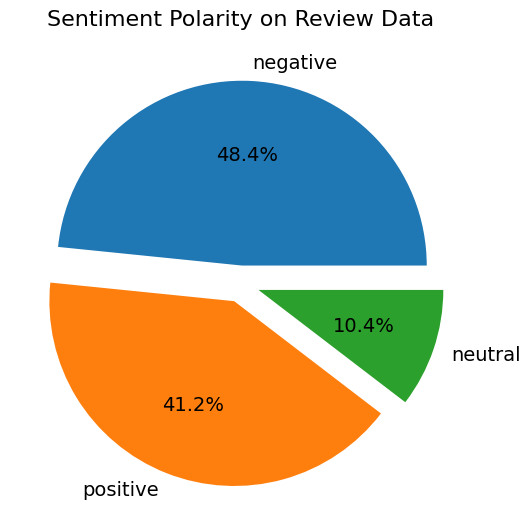

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis objects with a size of (6, 6) inches.
fig, ax = plt.subplots(figsize=(6, 6))

# Get the count of sentiment polarity from the 'clean_tkreviews' DataFrame and store it in the 'sizes' list.
sizes = [count for count in clean_fbreviews['polarity'].value_counts()]

# Get the sentiment category labels from the 'clean_tkreviews' DataFrame and store them in the 'labels' list.
labels = list(clean_fbreviews['polarity'].value_counts().index)

# Dynamically generate the explode tuple based on the number of labels
explode = (0.1,) * len(labels)  # Create an explode tuple where each slice is slightly exploded

# Create a pie chart with the data from 'sizes', 'labels', and 'explode' as defined.
# Autopct is used to display the percentage in each slice of the pie.
# Textprops is used to set the font size for the text in the pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Set the title for the pie chart with a specific font size and padding.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Display the pie chart.
plt.show()

In [ ]:
# Set the Pandas display option so that columns can show text up to 3000 characters.
pd.set_option('display.max_colwidth', 3000)

# Create a new DataFrame 'positive_reviews' that only contains reviews with positive polarity.
positive_reviews = clean_fbreviews[clean_fbreviews['polarity'] == 'positive']

# Select only specific columns from the 'positive_reviews' DataFrame.
positive_reviews = positive_reviews[['text_final', 'polarity_score', 'polarity', 'text_tokenizingText']]

# Sort the 'positive_reviews' DataFrame by 'polarity_score' in descending order.
positive_reviews = positive_reviews.sort_values(by='polarity_score', ascending=False)

# Reset the index of the DataFrame so it starts from 0.
positive_reviews = positive_reviews.reset_index(drop=True)

# Add 1 to all DataFrame indices to start from 1.
positive_reviews.index += 1

In [ ]:
# Set the Pandas display option so that columns can show text up to 3000 characters.
pd.set_option('display.max_colwidth', 3000)

# Create a new DataFrame 'negative_reviews' that only contains reviews with negative polarity.
negative_reviews = clean_fbreviews[clean_fbreviews['polarity'] == 'negative']

# Select only specific columns from the 'negative_reviews' DataFrame.
negative_reviews = negative_reviews[['text_final', 'polarity_score', 'polarity', 'text_tokenizingText']]

# Sort the 'negative_reviews' DataFrame by 'polarity_score' in ascending order.
negative_reviews = negative_reviews.sort_values(by='polarity_score', ascending=True)

# Select the first 10 rows from the sorted DataFrame.
negative_reviews = negative_reviews[0:10]

# Reset the index of the DataFrame so it starts from 0.
negative_reviews = negative_reviews.reset_index(drop=True)

# Add 1 to all DataFrame indices to start from 1.
negative_reviews.index += 1

In [ ]:
# Set the Pandas display option so that columns can show text up to 3000 characters.
pd.set_option('display.max_colwidth', 3000)

# Create a new DataFrame 'neutral_reviews' that only contains reviews with neutral polarity.
neutral_reviews = clean_fbreviews[clean_fbreviews['polarity'] == 'neutral']

# Select only specific columns from the 'neutral_reviews' DataFrame.
neutral_reviews = neutral_reviews[['text_final', 'polarity_score', 'polarity', 'text_tokenizingText']]

# Sort the 'neutral_reviews' DataFrame by 'polarity_score' in ascending order.
neutral_reviews = neutral_reviews.sort_values(by='polarity_score', ascending=True)

# Select the first 10 rows from the sorted DataFrame.
neutral_reviews = neutral_reviews[0:10]

# Reset the index of the DataFrame so it starts from 0.
neutral_reviews = neutral_reviews.reset_index(drop=True)

# Add 1 to all DataFrame indices to start from 1.
neutral_reviews.index += 1

['facebook', 'game', 'be', 'very', 'unstable', 'I', 'play', 'ludo', 'world', 'often', 'and', 'it', 'be', 'a', 'great', 'game', 'but', 'it', 'force', 'close', 'and', 'glitch', 'too', 'often', 'fix', 'this', 'please', 'if', 'you', 'be', 'go', 'to', 'offer', 'game', 'on', 'the', 'app', 'they', 'should', 'work', 'also', 'the', 'number', 'of', 'ad', 'be', 'ridiculous', 'especially', 'when', 'I', 'watch', 'the', 'whole', 'ad', 'then', 'get', 'kick', 'out', 'of', 'the', 'game', 'before', 'I', 'get', 'the', 'reward', 'and', 'have', 'to', 'watch', 'it', 'a', 'second', 'or', 'sometime', 'rd', 'time', 'to', 'get', 'the', 'reward', 'its', 'like', 'you', 'be', 'trick', 'people', 'into', 'watch', 'multiple', 'ad', 'for', 'nothing', 'dirty', 'tactic']['I', 'wish', 'I', 'do', 'not', 'have', 'to', 'use', 'it', 'video', 'live', 'stream', 'do', 'not', 'work', 'right', 'I', 'try', 'and', 'watch', 'it', 'horizontally', 'on', 'my', 'phone', 'and', 'the', 'app', 'place', 'half', 'the', 'screen', 'beneath', '

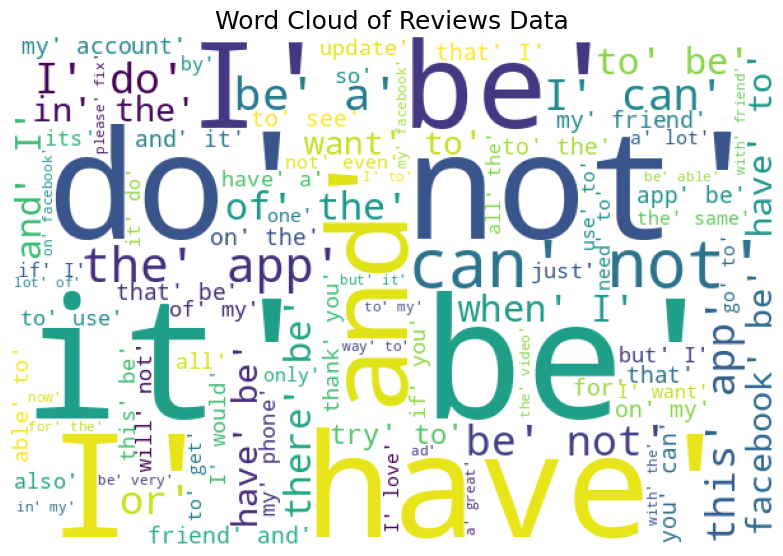

In [ ]:
# Create an empty string 'list_words' that will be used to collect all words from the balanced text.
list_words = ''

# Iterate through each review in the 'text_stopword' column of the 'clean_fbreviews' DataFrame.
count = 0
for review in clean_fbreviews['text_tokenizingText']:
  list_words += review
  count += 1
  if count == 10000:
    break

print(list_words)
# Create a WordCloud object with specific parameters.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Create a figure and axis to display the word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Set the title for the word cloud.
ax.set_title('Word Cloud of Reviews Data', fontsize=18)

# Disable the grid on the axis.
ax.grid(False)

# Display the word cloud in the figure.
ax.imshow(wordcloud)

# Adjust the layout of the figure.
fig.tight_layout(pad=0)

# Hide the axes.
ax.axis('off')

# Show the word cloud.
plt.show()

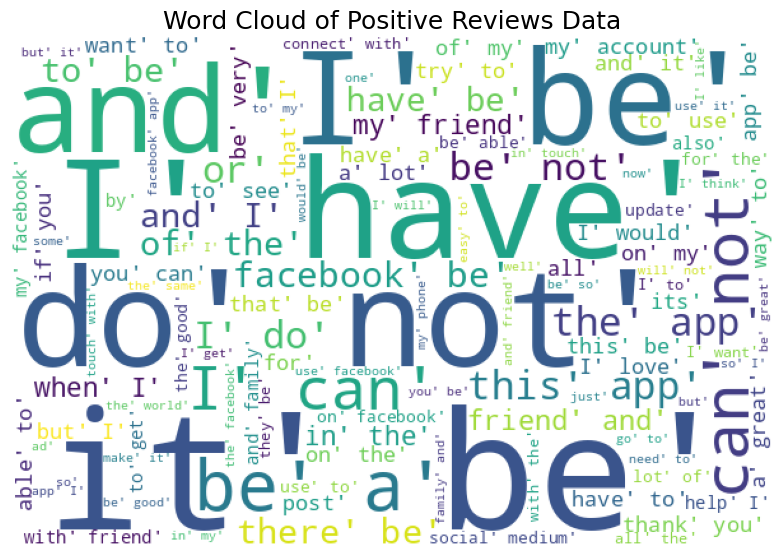

In [ ]:
# Create an empty string 'list_words' that will be used to collect all words from the positive reviews.
list_words = ''

# Iterate through each review in the 'text_tokenizingText' column of the 'positive_reviews' DataFrame.
count = 0
for review in positive_reviews['text_tokenizingText']:
  list_words += review
  count += 1
  if count == 10000:
    break

# Create a WordCloud object with specific parameters.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Create a figure and axis to display the word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Set the title for the word cloud.
ax.set_title('Word Cloud of Positive Reviews Data', fontsize=18)

# Disable the grid on the axis.
ax.grid(False)

# Display the word cloud in the figure.
ax.imshow(wordcloud)

# Adjust the layout of the figure.
fig.tight_layout(pad=0)

# Hide the axes.
ax.axis('off')

# Show the word cloud.
plt.show()

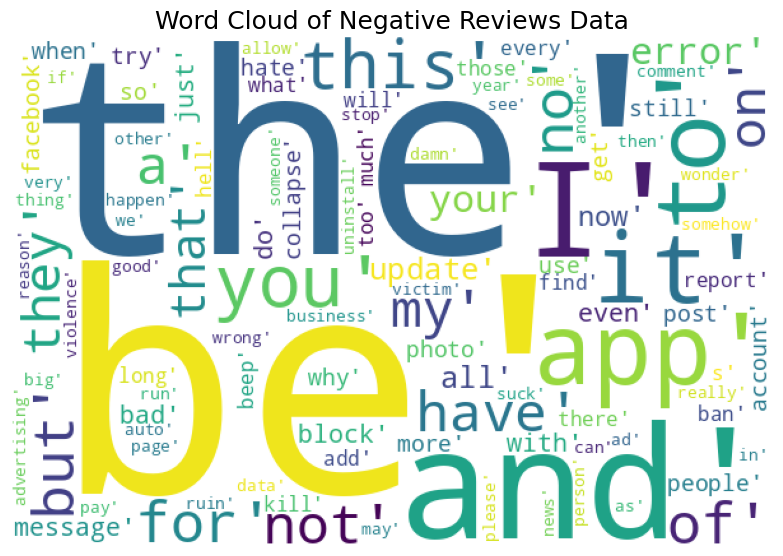

In [ ]:
# Create an empty string 'list_words' that will be used to collect all words from the negative reviews.
list_words = ''

# Iterate through each review in the 'text_tokenizingText' column of the 'negative_reviews' DataFrame.
count = 0
for review in negative_reviews['text_tokenizingText']:
  list_words += review
  count += 1
  if count == 10000:
    break


# Create a WordCloud object with specific parameters.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Create a figure and axis to display the word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Set the title for the word cloud.
ax.set_title('Word Cloud of Negative Reviews Data', fontsize=18)

# Disable the grid on the axis.
ax.grid(False)

# Display the word cloud in the figure.
ax.imshow(wordcloud)

# Adjust the layout of the figure.
fig.tight_layout(pad=0)

# Hide the axes.
ax.axis('off')

# Show the word cloud.
plt.show()

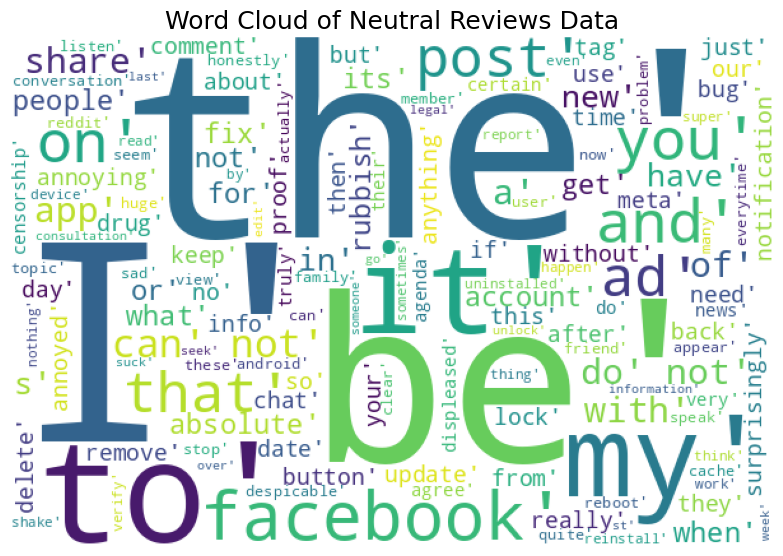

In [ ]:
# Create an empty string 'list_words' that will be used to collect all words from the neutral reviews.
list_words = ''

# Iterate through each review in the 'text_tokenizingText' column of the 'neutral_reviews' DataFrame.
count = 0
for review in neutral_reviews['text_tokenizingText']:
  list_words += review
  count += 1
  if count == 10000:
    break


# Create a WordCloud object with specific parameters.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Create a figure and axis to display the word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Set the title for the word cloud.
ax.set_title('Word Cloud of Neutral Reviews Data', fontsize=18)

# Disable the grid on the axis.
ax.grid(False)

# Display the word cloud in the figure.
ax.imshow(wordcloud)

# Adjust the layout of the figure.
fig.tight_layout(pad=0)

# Hide the axes.
ax.axis('off')

# Show the word cloud.
plt.show()

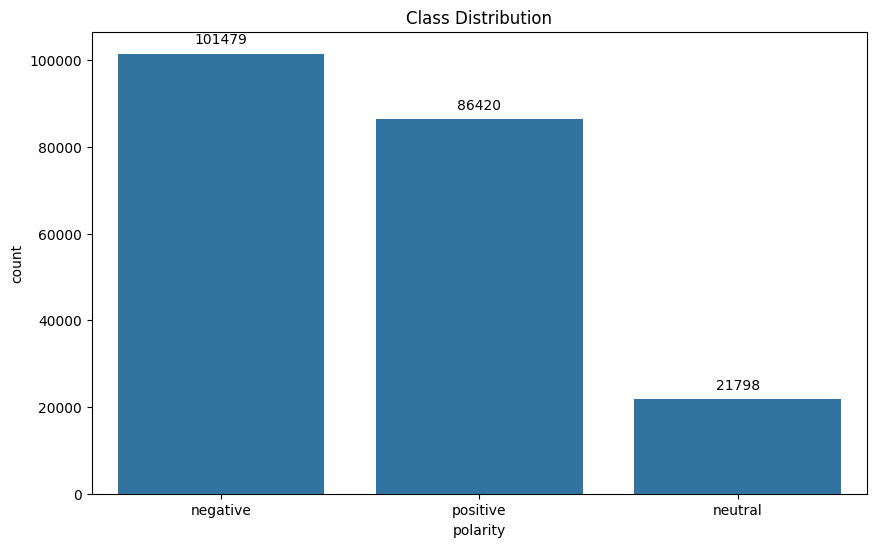

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize class distribution of polarities (positive, negative, neutral)
class_dist_plot = sns.countplot(x='polarity', data=clean_fbreviews)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

plt.show()

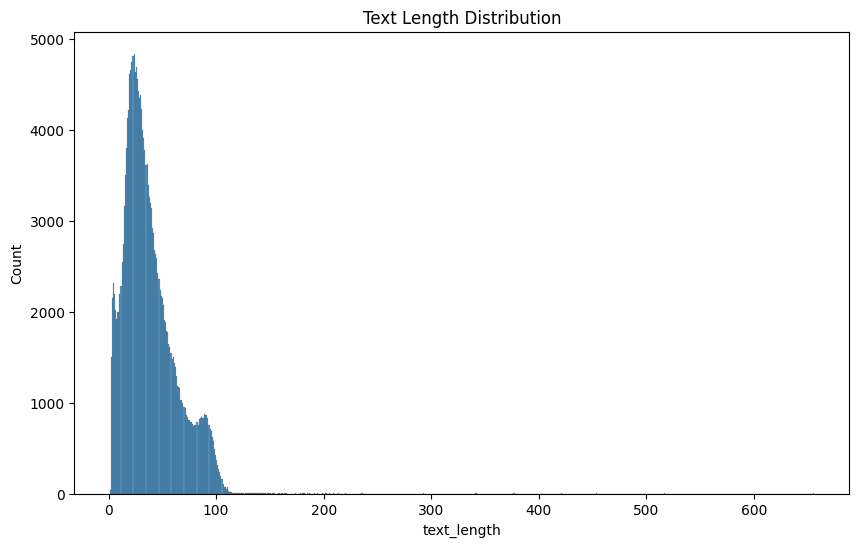

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize review text length distribution
clean_fbreviews['text_length'] = clean_fbreviews['text_final'].apply(lambda x: len(x.split()))
sns.histplot(clean_fbreviews['text_length'])
plt.title('Text Length Distribution')
plt.show()

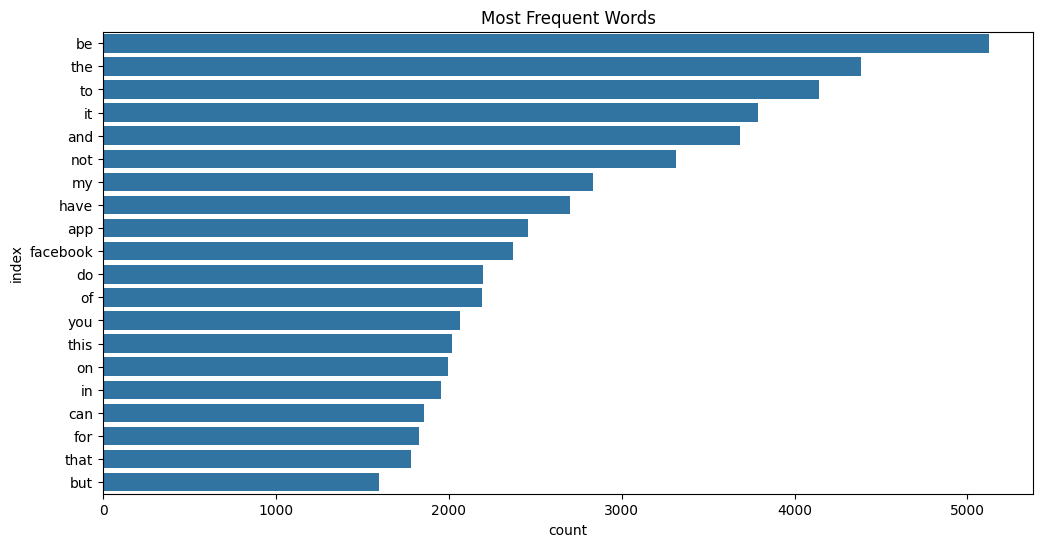

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_fbreviews['text_final'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='count')
tfidf_df = tfidf_df.sort_values('count', ascending=False).head(20)
sns.barplot(x='count', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## Model Training

We will using various architectures for training our deep learning models for our sentiment analysis

But first lets convert our labels into meaning numerical representaion for our Models to understand

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 1
    elif score <= -0.05:
        return -1
    else:
        return 0

In [ ]:
clean_fbreviews = pd.read_csv('/content/drive/MyDrive/facebook_reviews_cleaned.csv')

In [ ]:
# Assume your dataset is in a DataFrame called `df` with column 'review'
clean_fbreviews['label'] = clean_fbreviews['text_final'].apply(get_sentiment)


texts = clean_fbreviews['text_final'].tolist()
labels = clean_fbreviews['label'].map({-1: 0, 0: 1, 1: 2}).tolist()  # Convert to 0,1,2 for 3-class

In [ ]:
clean_fbreviews.head()

reviewId       userName  \
0  98efbc0a-faf1-49d5-8f9e-f3495c0086a8  A Google user   
1  4fdd5f9c-d80d-4679-a243-84ff42c05a7d  A Google user   
2  e2466ee6-e85c-43c8-b8cc-29a41906605f  A Google user   
3  1e18fb86-165a-4e3e-9329-7128eae954a2  A Google user   
4  91620db6-5cec-47ac-a6a4-c88582de0a35  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Constantly freezes and shuts down. They never ...      1           1967   
1  Facebook games are very unstable!!!! I play Lu...      1           1919   
2  Please reset the search options. I used to be ...      1           8838   
3  3/2/23: Can you please stop making every updat...      2           4578   
4  The User Interface of this app is one of the w...      1           9953   

  reviewCreatedVersion                   at  replyContent  repliedAt  \
0        504.0.0.69.64  2025-03-23 18:56:08           NaN        NaN   
1        505.0.0.57.45  2025-03-20 22:33:52           NaN        NaN   
2        503.0.0.69.76  2025-03-13 11:43:54           NaN        NaN   
3        502.0.0.66.79  2025-03-06 03:15:54           NaN        NaN   
4        496.0.0.45.65  2025-01-20 05:43:42           NaN        NaN   

      appVersion                               text_casefoldingText  \
0  504.0.0.69.64  constantly freezes and shuts down. they never ...   
1  505.0.0.57.45  facebook games are very unstable!!!! i play lu...   
2  503.0.0.69.76  please reset the search options. i used to be ...   
3  502.0.0.66.79  3/2/23: can you please stop making every updat...   
4  496.0.0.45.65  the user interface of this app is one of the w...   

                                     text_slangwords  \
0  constantly freezes and shuts down. they never ...   
1  facebook games are very unstable!!!! i play lu...   
2  please reset the search options. i used to be ...   
3  3/2/23: can you please stop making every updat...   
4  the user interface of this app is one of the w...   

                                text_lemmitizingText  \
0  constantly freeze and shut down . they never s...   
1  facebook game be very unstable ! ! ! ! I play ...   
2  please reset the search option . I use to be a...   
3  3/2/23 : can you please stop make every update...   
4  the user interface of this app be one of the b...   

                                          text_clean  \
0  constantly freeze and shut down they never see...   
1  facebook game be very unstable I play ludo wor...   
2  please reset the search option I use to be abl...   
3  can you please stop make every update come wit...   
4  the user interface of this app be one of the b...   

                                 text_tokenizingText  \
0  ['constantly', 'freeze', 'and', 'shut', 'down'...   
1  ['facebook', 'game', 'be', 'very', 'unstable',...   
2  ['please', 'reset', 'the', 'search', 'option',...   
3  ['can', 'you', 'please', 'stop', 'make', 'ever...   
4  ['the', 'user', 'interface', 'of', 'this', 'ap...   

                                          text_final  polarity_score  polarity  
0  constantly freeze and shut down they never see...         -0.4215  negative  
1  facebook game be very unstable I play ludo wor...          0.9651  positive  
2  please reset the search option I use to be abl...         -0.0531   neutral  
3  can you please stop make every update come wit...          0.2862   neutral  
4  the user interface of this app be one of the b...         -0.8756  negative

## Multi-Layer Perceptron for Bag Of Words

A `Multi Layer Perceptron (MLP)` is one of the most fundamental architectures in deep learning. It consists of fully connected layers (also known as Dense Layers) where each neuron in a layer is connected to every neuron in the previous and next layers. The output of each layer is typically passed through a non-linear activation function like ReLU or sigmoid, which helps the model learn complex relationships in the data.

---

To feed textual data into an MLP, we need to convert words into a numerical form. One simple and widely used method for this is the `Bag of Words (BoW)` approach.

**How BoW Works:**

* Each unique word in the corpus is assigned a unique index.

* Sentences or documents are then converted into vectors where each element represents the presence (or frequency) of a word in that document, ignoring the order or context of the words.

* In our case, instead of using sparse vectors (like one-hot or frequency), we convert words to learnable embeddings, where each token is mapped to a dense, low-dimensional vector using an embedding layer.

* These word embeddings are then merged (via averaging, summing, or concatenating) to form a fixed-size input representation for the MLP.

**Embeddings** are dense, low-dimensional vector representations of data — in our case, words or tokens — where similar meanings are placed closer together in the vector space.

Instead of representing a word as a sparse one-hot vector (mostly zeros), embeddings capture semantic relationships by learning from data. For example, the words "king" and "queen" might have similar embeddings because they appear in similar contexts.

These embeddings are learned during training, meaning the model figures out which words are related or important based on the task it's optimizing for.

This way of merged embedding approach for training a neural network is called Bag Of Words since they are essentially just a group of words irrespective of their position in the sequence

**Simple and Efficient:** BoW is computationally light and easy to implement, especially useful for baseline models or smaller datasets.

**Suitable for MLPs:** Since MLPs do not have a notion of sequential data or context, BoW complements it by providing a flat, fixed-size representation.

**Learnable Representations:** When combined with embedding layers, the model can learn semantic relationships between words based on the task at hand.

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Save best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_mlp.keras',          # File name
    monitor='val_accuracy',          # Metric to monitor
    save_best_only=True,             # Only save if it's the best
    mode='max',                      # Because higher accuracy = better
    verbose=1                        # Print when model is saved
)

In [ ]:
# Example: setting a custom learning rate
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test, y_test_cat), callbacks=[checkpoint])

Epoch 1/10
5243/5243 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6922 - loss: 0.6929
Epoch 1: val_accuracy improved from -inf to 0.83794, saving model to best_model.keras
5243/5243 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6922 - loss: 0.6928 - val_accuracy: 0.8379 - val_loss: 0.4333
Epoch 2/10
5224/5243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8278 - loss: 0.4543
Epoch 2: val_accuracy did not improve from 0.83794
5243/5243 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8278 - loss: 0.4542 - val_accuracy: 0.7778 - val_loss: 0.5580
Epoch 3/10
5240/5243 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.4136
Epoch 3: val_accuracy improved from 0.83794 to 0.85649, saving model to best_model.keras
5243/5243 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8439 - loss: 0.4136 - val_accuracy: 0.8565 - val_loss: 0.3897
Epoch 4/10
5241/5243 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.3726
Epoch 4: val_accuracy improved from 0.85649 to 0.85715, saving

In [ ]:
model.evaluate(X_test, y_test_cat)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8666 - loss: 0.3708


[0.37502431869506836, 0.8668335676193237]

## Long Short-Term Memory (LSTM) for Sequence of Words


An `LSTM (Long Short-Term Memory)` is a type of **Recurrent Neural Network (RNN)** architecture specifically designed to handle sequential data, such as text, speech, or time-series signals. Unlike traditional feedforward networks like MLPs, LSTMs maintain an internal memory of past inputs, allowing them to understand the order and context of words in a sequence.

This makes them ideal for tasks where word order and temporal dependencies matter, such as sentiment analysis, speech recognition, and language modeling.

At each time step (e.g., each word in a sentence), the LSTM takes in the current input and the hidden state from the previous time step. What makes LSTMs powerful is their gating mechanism, which controls the flow of information:

* **Forget Gate:** Decides what part of the past information to discard from the memory.

* **Input Gate:** Determines what new information to add to the memory.

* **Output Gate:** Decides what information from the memory should be passed to the next step (i.e., the next word or time step).

This combination allows LSTMs to retain important information over long sequences while discarding irrelevant details — something standard RNNs struggle with due to the vanishing gradient problem.

Unlike Bag of Words, LSTMs consider the position and relationship between words.

LSTMS are useful for understanding dependencies like “not good” versus “very good”.

They are suitable for Variable-Length Sequences: LSTMs can process inputs of different lengths without needing fixed-size representations.

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.3, random_state=42, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=100),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Save best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_lstm.keras',         # File name
    monitor='val_accuracy',          # Metric to monitor
    save_best_only=True,             # Only save if it's the best
    mode='max',                      # Because higher accuracy = better
    verbose=1                        # Print when model is saved
)

In [ ]:
# Example: setting a custom learning rate
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test, y_test_cat), callbacks=[checkpoint])

Epoch 1/10
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5799 - loss: 0.8045
Epoch 1: val_accuracy improved from -inf to 0.90356, saving model to best_model_lstm.keras
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.5799 - loss: 0.8045 - val_accuracy: 0.9036 - val_loss: 0.2759
Epoch 2/10
4586/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9358 - loss: 0.1931
Epoch 2: val_accuracy improved from 0.90356 to 0.94594, saving model to best_model_lstm.keras
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - accuracy: 0.9358 - loss: 0.1930 - val_accuracy: 0.9459 - val_loss: 0.1603
Epoch 3/10
4584/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9568 - loss: 0.1231
Epoch 3: val_accuracy improved from 0.94594 to 0.94742, saving model to best_model_lstm.keras
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9568 - loss: 0.1231 - val_accuracy: 0.9474 - val_loss: 0.1509
Epoch 4/10
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9645 - loss: 0.0992
Epoch 

## Convolution Neural Network (CNN) for N-Gram

Absolutely! Here's a clear, presentable explanation tailored for your CNN-based model applied to text, keeping in line with the style of your MLP and LSTM sections:

---

### **Convolutional Neural Networks (CNNs) for Text**

Although originally designed for image processing, **Convolutional Neural Networks (CNNs)** have proven highly effective for **text classification** tasks as well. CNNs are particularly good at **capturing local patterns** — such as phrases or combinations of neighboring words — that are critical in determining the meaning or sentiment of a sentence.

In the context of text, a CNN operates on **word embeddings**, which convert words into dense vectors (as discussed earlier), preserving semantic information.

#### **How CNN Works for Text:**

- The model starts with an **Embedding layer** that transforms each word into a vector, creating a 2D matrix (like an image, but for words).
- A **1D Convolutional layer (Conv1D)** slides filters over the sequence of word vectors. These filters act like detectors for specific **n-gram patterns** (e.g., “not good”, “very bad”, “extremely helpful”).
- Each filter captures a specific local pattern, and multiple filters learn different features in parallel.
- The **Global Max Pooling layer** selects the most prominent signal from each filter — essentially keeping the strongest features across the entire text, no matter where they occur.
- The pooled features are passed through **Dense layers** for classification, eventually predicting the sentiment or class using a **softmax** layer (for multiclass classification).

CNN ocuses on the most informative local patterns, regardless of their position in the text.

Unlike LSTMs, CNNs do not depend on processing the sequence step-by-step and are faster to train.

They are especially effective when input sequences are padded/truncated to a fixed length, as in our case (`input_length=100`).

When combined with max pooling, CNNs highlight the most important features, making them excellent for text classification.

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.3, random_state=42, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
# Save best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_cnn.keras',          # File name
    monitor='val_accuracy',          # Metric to monitor
    save_best_only=True,             # Only save if it's the best
    mode='max',                      # Because higher accuracy = better
    verbose=1                        # Print when model is saved
)

In [ ]:
# Example: setting a custom learning rate
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test, y_test_cat), callbacks=[checkpoint])

Epoch 1/10
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.4815
Epoch 1: val_accuracy improved from -inf to 0.90699, saving model to best_model_cnn.keras
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.8054 - loss: 0.4815 - val_accuracy: 0.9070 - val_loss: 0.2589
Epoch 2/10
4587/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9228 - loss: 0.2190
Epoch 2: val_accuracy improved from 0.90699 to 0.91505, saving model to best_model_cnn.keras
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9228 - loss: 0.2190 - val_accuracy: 0.9151 - val_loss: 0.2414
Epoch 3/10
4574/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9431 - loss: 0.1625
Epoch 3: val_accuracy did not improve from 0.91505
4588/4588 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9431 - loss: 0.1625 - val_accuracy: 0.9122 - val_loss: 0.2624
Epoch 4/10
4572/4588 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1255
Epoch 4: val_accuracy did not improve from 0.91505
458

## Model Testing

In [ ]:
mlp_model = load_model('best_model_mlp.keras')
lstm_model = load_model('best_model_lstm.keras')
cnn_model = load_model('best_model_cnn.keras')

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
mlp_train_acc, mlp_test_acc = mlp_model.evaluate(X_train, y_train_cat, verbose=0), mlp_model.evaluate(X_test, y_test_cat, verbose=0)
lstm_train_acc, lstm_test_acc = lstm_model.evaluate(X_train, y_train_cat, verbose=0), lstm_model.evaluate(X_test, y_test_cat, verbose=0)
cnn_train_acc, cnn_test_acc = cnn_model.evaluate(X_train, y_train_cat, verbose=0), cnn_model.evaluate(X_test, y_test_cat, verbose=0)

In [ ]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['MLP', 'LSTM', 'CNN'],
    'Accuracy Train': [mlp_train_acc[1], lstm_train_acc[1], cnn_train_acc[1]],
    'Accuracy Test': [mlp_test_acc[1], lstm_test_acc[1], cnn_test_acc[1]]
})
# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
accuracy_test_only

Model  Accuracy Test
0   MLP       0.868097
1  LSTM       0.952551
2   CNN       0.915808

**Observation:**

We achieved above **85%** Test Accuracy for MLP and Above **90%** for CNN and LSTM showcasing how even simple MLP model can perform well for text classification through efficient use of word embeddings

Meanwhile we can observe that while LSTM turns out to be the best approach for a sequence based tast such as texts even CNN which is primarily used for images have show significant results for text based tasks

## Model Inference

We can use our trained model for inference and classification of our texts

In [ ]:
def predict_sentiment(text, tokenizer, mlp_model, lstm_model, cnn_model):
    # Preprocess the text
    casefolded_text = casefoldingText(text)
    slang_text = fix_slangwords(casefolded_text)
    lemmatized_text = lemmitizingText(slang_text)
    cleaned_text = cleaningText(lemmatized_text)

    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')

    # Make predictions for each model
    mlp_output = ['negative', 'neutral', 'positive'][np.argmax(mlp_model.predict(padded), axis=1)[0]]
    lstm_output = ['negative', 'neutral', 'positive'][np.argmax(lstm_model.predict(padded), axis=1)[0]]
    cnn_output = ['negative', 'neutral', 'positive'][np.argmax(cnn_model.predict(padded), axis=1)[0]]

    # Print the predicted sentiment for each model
    print(f"MLP Model Predicted Sentiment: {mlp_output}")
    print(f"LSTM Model Predicted Sentiment: {lstm_output}")
    print(f"CNN Model Predicted Sentiment: {cnn_output}")

In [ ]:
mlp_model = load_model('best_model_mlp.keras')
lstm_model = load_model('best_model_lstm.keras')
cnn_model = load_model('best_model_cnn.keras')

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
text = input("Enter text for sentiment prediction: ")
predict_sentiment(text, tokenizer, mlp_model, lstm_model, cnn_model)

Enter text for sentiment prediction: I really dont like this application
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
MLP Model Predicted Sentiment: negative
LSTM Model Predicted Sentiment: negative
CNN Model Predicted Sentiment: negative


In [ ]:
text = input("Enter text for sentiment prediction: ")
predict_sentiment(text, tokenizer, mlp_model, lstm_model, cnn_model)

Enter text for sentiment prediction: I love this application
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
MLP Model Predicted Sentiment: positive
LSTM Model Predicted Sentiment: positive
CNN Model Predicted Sentiment: positive


In [ ]:
text = input("Enter text for sentiment prediction: ")
predict_sentiment(text, tokenizer, mlp_model, lstm_model, cnn_model)

Enter text for sentiment prediction: I went to market today
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MLP Model Predicted Sentiment: neutral
LSTM Model Predicted Sentiment: neutral
CNN Model Predicted Sentiment: neutral
